In [1]:
import warnings

import itertools
import numpy as np
import pandas as pd

import gensim
from string import punctuation
from nltk import word_tokenize

from typing import List

from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import xgboost as xgb

from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

punctuation += '«»–—…“”'

# Voting

In [2]:
data_url = 'https://raw.githubusercontent.com/TatianaShavrina/hse_ml_m1/master/ensembles/complaints.csv'
data = pd.read_csv(data_url, sep='\t')
data.head()

,COMPLAINT_ID,DATE,PRODUCT_ID,ISSUE_ID,cleaned_text
0,3178905,03/13/2019,44,318,go year . contact advis never took loan . advi...
1,3175952,03/12/2019,44,349,"mail valid debt xx/xx/19 valid receiv , receiv..."
2,3174747,03/09/2019,44,16,xx/xx/xxxx appli receiv onlin loan bluechip fi...
3,3173291,03/08/2019,44,16,xx/xx/xxxx appli receiv onlin loan . loan amou...
4,3172221,03/07/2019,44,48,told husband left bill . debt would pay within...


In [3]:
y = data['PRODUCT_ID']
X = data['cleaned_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [4]:
def preprocess(text: str) -> str:
    return text.strip().lower()

def tokenize(text: str) -> List[str]:
    tokens = []
    for token in word_tokenize(text):
        token_stripped = token.strip(punctuation)
        if token_stripped:
            tokens.append(token_stripped)
    return tokens

In [5]:
EMB_DIM = 100

w2v = gensim.models.Word2Vec(X_train, size=EMB_DIM, sg=1, negative=20, window=10)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = EMB_DIM

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in word_tokenize(words) if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [6]:
clfs = VotingClassifier(estimators=[
    (f'lr_{i}', LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=i, max_iter=1000)) for i in range(1, 11)
] + [
    (f'svc_{i}', SVC(class_weight='balanced', random_state=i)) for i in range(1, 11)
], voting='hard')


voting = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                  tokenizer=tokenize, ngram_range=(1, 3),
                                  max_df=0.9, min_df=50, max_features=1000)),
        ('word2vec', MeanEmbeddingVectorizer(w2v))])),
    ('clf', clfs)
])
voting = voting.fit(X_train, y_train)

In [7]:
predictions = voting.predict(X_test)
print('Precision: {0:6.2f}'.format(precision_score(y_test, predictions, average='macro')))
print('Recall: {0:6.2f}'.format(recall_score(y_test, predictions, average='macro')))
print('F1-measure: {0:6.2f}'.format(f1_score(y_test, predictions, average='macro')))
print('Accuracy: {0:6.2f}'.format(accuracy_score(y_test, predictions)))

Precision:   0.68
Recall:   0.68
F1-measure:   0.68
Accuracy:   0.67


# Ensembles

## XGBoost

In [8]:
clf = xgb.XGBClassifier(objective='multi:softmax')

xgb_pipe = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                  tokenizer=tokenize, ngram_range=(1, 3),
                                  max_df=0.9, min_df=50, max_features=1000)),
        ('word2vec', MeanEmbeddingVectorizer(w2v))])),
    ('clf', clf)
])
xgb_pipe = xgb_pipe.fit(X_train, y_train)

In [9]:
predictions = xgb_pipe.predict(X_test)
print('Precision: {0:6.2f}'.format(precision_score(y_test, predictions, average='macro')))
print('Recall: {0:6.2f}'.format(recall_score(y_test, predictions, average='macro')))
print('F1-measure: {0:6.2f}'.format(f1_score(y_test, predictions, average='macro')))
print('Accuracy: {0:6.2f}'.format(accuracy_score(y_test, predictions)))

Precision:   0.70
Recall:   0.70
F1-measure:   0.70
Accuracy:   0.70


## Stacking

In [10]:
clf1 = KNeighborsClassifier(n_neighbors=50)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GaussianNB()
clf4 = SVC(class_weight='balanced', random_state=42)
clf5 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
clf6 = xgb.XGBClassifier(objective='multi:softmax')

lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3, clf4, clf5, clf6],
                          meta_classifier=lr)

In [11]:
data_pipe = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                  tokenizer=tokenize, ngram_range=(1, 3),
                                  max_df=0.9, min_df=50, max_features=1000)),
        ('word2vec', MeanEmbeddingVectorizer(w2v))]))
])

X_np = data_pipe.fit_transform(X).todense()
y_np = np.array(y)

In [12]:
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6, sclf]
labels = ['KNN', 'Random Forest', 'Naive Bayes', 'SVM', 'LR', 'XGB', 'Stacking Classifier']

for clf, label in zip(clf_list, labels):
    scores = cross_val_score(clf, X_np, y_np, cv=3, scoring='accuracy')
    print ('Accuracy: %.2f (+/- %.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.57 (+/- 0.01) [KNN]
Accuracy: 0.59 (+/- 0.00) [Random Forest]
Accuracy: 0.57 (+/- 0.01) [Naive Bayes]
Accuracy: 0.64 (+/- 0.01) [SVM]
Accuracy: 0.64 (+/- 0.00) [LR]
Accuracy: 0.63 (+/- 0.01) [XGB]
Accuracy: 0.30 (+/- 0.02) [Stacking Classifier]


In [16]:
sclf_pipe = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                  tokenizer=tokenize, ngram_range=(1, 3),
                                  max_df=0.9, min_df=50, max_features=1000)),
        ('word2vec', MeanEmbeddingVectorizer(w2v))])),
    ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=False)),
    ('clf', sclf)
])

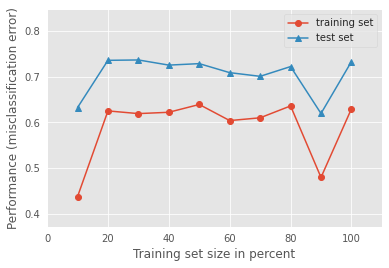

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf_pipe, print_model=False, style='ggplot')
plt.show()

In [20]:
sclf_pipe = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(analyzer='word', preprocessor=preprocess,
                                  tokenizer=tokenize, ngram_range=(1, 3),
                                  max_df=0.9, min_df=50, max_features=1000)),
        ('word2vec', MeanEmbeddingVectorizer(w2v))])),
    ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True, validate=False)),
    ('clf', sclf)
])

sclf_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tfidf',
                                                 TfidfVectorizer(analyzer='word',
                                                                 binary=False,
                                                                 decode_error='strict',
                                                                 dtype=<class 'numpy.float64'>,
                                                                 encoding='utf-8',
                                                                 input='content',
                                                                 lowercase=True,
                                                                 max_df=0.9,
                                                                 max_features=1000,
                                                                 min_df=50,
                    

In [21]:
predictions = sclf_pipe.predict(X_test)
print('Precision: {0:6.2f}'.format(precision_score(y_test, predictions, average='macro')))
print('Recall: {0:6.2f}'.format(recall_score(y_test, predictions, average='macro')))
print('F1-measure: {0:6.2f}'.format(f1_score(y_test, predictions, average='macro')))
print('Accuracy: {0:6.2f}'.format(accuracy_score(y_test, predictions)))

Precision:   0.24
Recall:   0.27
F1-measure:   0.22
Accuracy:   0.27


For some reason, stacking does not work very well at all even though the individual classifiers work fine. However, we have been able to achieve 70% accuracy and F1 with the use of XGBoost.